# Duke Image Reconstruction Testing

In [ ]:
# B0 inhomogeneity correction step
def correct_b0(
        image: np.ndarray, mask: np.ndarray, max_iterations: int = 100
    ) -> np.ndarray:
        index = 0
        meanphase = 1
        while abs(meanphase) > 1e-7:
            index = index + 1
            diffphase = np.angle(image)
            meanphase = np.mean(diffphase[mask])  # type: ignore
            image = np.multiply(image, np.exp(-1j * meanphase))
            if index > max_iterations:
                break
        return np.angle(image)  # type: ignore
    
def normalize_images(images):
    # initial zero ndarray
    normalized_images = np.zeros_like(images.astype(float))
    # first  index is number of images
    #other indices indicates height, width, depth of the image
    num_images = images.shape[0]
    # computing the minimum and maximum value of the input image for normalization 
    maximum_value, minimum_value = images.max(), images.min()
    # normalize all the pixel values of the images to be from 0 to 1
    for img in range(num_images):
        normalized_images[img, ...] = (images[img, ...] - float(minimum_value)) / ...
        float(maximum_value - minimum_value)
    return normalized_images
    
# create mask with normal threshold method
imgGasHiSNRNorm=normalize_images(abs(image_gas_highsnr))
threshold_value=0.5
mask_hiSNR = abs(imgGasHiSNRNorm) > threshold_value

# correct B0 inhomogeneity
diffphase = correct_b0(image_gas_highsnr, mask_hiSNR)
# calculate phase shift to separate RBC and membrane
desired_angle = np.arctan2(rbc_m_ratio, 1.0)  # calculated from the flipcal file
desired_angle = 45*np.pi/180
current_angle = np.angle(np.sum(image_dissolved[mask_hiSNR > 0]))
delta_angle = desired_angle - current_angle
image_dixon = np.multiply(image_dissolved, np.exp(1j * (delta_angle)))
image_dixon = np.multiply(image_dixon, np.exp(1j * (-diffphase)))

# separate RBC and membrane components
image_rbc = (np.imag(image_dixon)
                if np.mean(np.imag(image_dixon)[mask_hiSNR]) > 0
                else -1 * np.imag(image_dixon)  # type: ignore
            )
image_membrane = (np.real(image_dixon)
                if np.mean(np.real(image_dixon)[mask_hiSNR]) > 0
                else -1 * np.real(image_dixon)  # type: ignore
            )
    

## Import Libraries

In [1]:
import pickle
from scipy.io import loadmat
import tkinter as tk
from tkinter import filedialog
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.util

from main.DukeImageRecon import ImageRecon
# two input arguments: data, trajectory
from main.DukeDixonDecon import DixonDecon
# three input arguments: dictionary (from flip cal data), high SNR gas image, dissolved image

parent_dir = os.getcwd()
N = 128
I = 1j

## Load Data

In [2]:
# DATA
# create a Tkinter root window (it won't be shown)
root = tk.Tk()
root.withdraw()  # hide the main window
# ask the user to select the file
file_path = filedialog.askopenfilename(title="Select the Phasor/Data File")
phasors_128 = np.load(file_path)
phasors_128 = phasors_128.reshape((phasors_128.shape[0], 1))

In [3]:
# TRAJECTORY
# loading trajectory 
if parent_dir.endswith('DukeRecon'):
    os.chdir('..')
traj = loadmat('traj/traj_gas_afia.mat')
current_dir = os.getcwd()
# k-space x, y, and z points 
kx = traj['data'][:,:,0].ravel()
ky = traj['data'][:,:,1].ravel()
kz = traj['data'][:,:,2].ravel()
# rescaling based on N
#kx = kx*N
#ky = ky*N
#kz = kz*N
# trajectory has already been scaled!
trajlist = np.column_stack((kx, ky, kz))

In [4]:
# DICTIONARY
# load in dictionary (created using flip cal data) from a real data example
# can change later...
os.chdir(os.path.join(current_dir, 'DataSynthesizer/data'))
with open('Xe0067Pre_dict_dyn.pkl', 'rb') as pickle_file:
    dict_dyn = pickle.load(pickle_file)

## Run Image Reconstruction

In [5]:
image_gas_highreso, image_gas_highsnr, image_dissolved = ImageRecon(phasors_128, trajlist, data_type='synthesized')

Execution time: 6.32 seconds
Execution time: 9.05 seconds
Execution time: 5.12 seconds


## Run Dixon Deconstruction

In [7]:
image_membrane, image_rbc, mask, diffphase = DixonDecon(dict_dyn, image_gas_highsnr, image_dissolved, data_type='synthesized')

RBC/M Ratio: 1.047285


In [8]:
# display DP modulus, DP phase, mask, diffphase, membrane, and rbc images 
modulus = np.abs(image_dissolved)
phase = np.angle(image_dissolved)

fig, axes = plt.subplots(1, 6, figsize=(4 * 6, 4))

# DP modulus
axes[0].imshow(skimage.util.montage([modulus[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[0].set_title('DP Modulus')
           
# DP phase
axes[1].imshow(skimage.util.montage([phase[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[1].set_title('DP Phase')
               
# mask image
axes[2].imshow(skimage.util.montage([mask[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[2].set_title('Mask')

# diffphase image
axes[3].imshow(skimage.util.montage([diffphase[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[3].set_title('Diffphase')

# membrane image
axes[4].imshow(skimage.util.montage([image_membrane[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[4].set_title('Membrane')

# rbc image
axes[5].imshow(skimage.util.montage([image_rbc[:,:,k] for k in range(60, 69)], padding_width=1, fill=0), cmap='gray')
axes[5].set_title('RBC')

plt.show()

## Extra Functions for Exploring

In [17]:
def DisplayImageSlice(image, slice_id=N//2, image_type='modulus'):
    
    # display real component
    if image_type == 'real' or  image_type == 'Real': 
        plt.imshow(np.real(image[:,:,slice_id])) # default is center slice 
        plt.title('Real Component of Image (2D Slice)') 
    # display imaginary component
    elif image_type == 'imag' or  image_type == 'Imag' or image_type == 'imaginary' or image_type == 'Imaginary':
        plt.imshow(np.imag(image[:,:,slice_id]))
        plt.title('Imaginary Component of Image (2D Slice)') # default is center slice 
    else: # display modulus (default)
        plt.imshow(np.abs(image[:,:,slice_id]))
        plt.title('Modulus Component of Image (2D Slice)') # default is center slice 

    plt.colorbar()
    plt.show()

In [9]:
def makeSlide(A):
    ''' displays 3D array as a 2D grayscale image montage'''
    plt.imshow(skimage.util.montage([abs(A[:,:,k]) 
                                     for k in range(0,A.shape[2])], padding_width=1, fill=0))
    plt.show()

## Examining Images

In [10]:
DisplayImageSlice(image_gas_highreso)

In [11]:
DisplayImageSlice(image_membrane)

In [12]:
DisplayImageSlice(image_rbc)

## Comparison with Perfect/Original Image

In [14]:
image128_original = np.load('3D_binary_multisphere_original_image_128.npy')

In [15]:
makeSlide(image128_original)

In [16]:
DisplayImageSlice(image128_original)

## Old Code Setup... 

In [ ]:
import pdb
import numpy as np
from absl import app, logging
import time
from recon import dcf, kernel, proximity, recon_model, system_model
from utils import io_utils
from matplotlib import pyplot as plt
import skimage.util

import os
parent_dir = os.getcwd()
N = 128
I = 1j

In [2]:
def DisplayImageSlice(image, slice_id=N//2, image_type='modulus'):
    
    # display real component
    if image_type == 'real' or  image_type == 'Real': 
        plt.imshow(np.real(image[:,:,slice_id])) # default is center slice 
        plt.title('Real Component of Image (2D Slice)') 
    # display imaginary component
    elif image_type == 'imag' or  image_type == 'Imag' or image_type == 'imaginary' or image_type == 'Imaginary':
        plt.imshow(np.imag(image[:,:,slice_id]))
        plt.title('Imaginary Component of Image (2D Slice)') # default is center slice 
    else: # display modulus (default)
        plt.imshow(np.abs(image[:,:,slice_id]))
        plt.title('Modulus Component of Image (2D Slice)') # default is center slice 

    plt.colorbar()
    plt.show()

In [3]:
def makeSlide(A):
    ''' displays 3D array as a 2D grayscale image montage'''
    plt.imshow(skimage.util.montage([abs(A[:,:,k]) 
                                     for k in range(0,A.shape[2])], padding_width=1, fill=0))
    plt.show()

In [4]:
# Duke's main recon function 
def reconstruct(
    data: np.ndarray,
    traj: np.ndarray,
    kernel_sharpness: float = 0.32,
    kernel_extent: float = 0.32 * 9,
    overgrid_factor: int = 3,
    image_size: int = 128,
    n_dcf_iter: int = 20,
    verbosity: bool = True,
) -> np.ndarray:
    """Reconstruct k-space data and trajectory.

    Args:
        data (np.ndarray): k space data of shape (K, 1)
        traj (np.ndarray): k space trajectory of shape (K, 3)
        kernel_sharpness (float): kernel sharpness. larger kernel sharpness is sharper
            image
        kernel_extent (float): kernel extent.
        overgrid_factor (int): overgridding factor
        image_size (int): target reconstructed image size
            (image_size, image_size, image_size)
        n_pipe_iter (int): number of dcf iterations
        verbosity (bool): Log output messages

    Returns:
        np.ndarray: reconstructed image volume
    """
    start_time = time.time()
    prox_obj = proximity.L2Proximity(
        kernel_obj=kernel.Gaussian(
            kernel_extent=kernel_extent,
            kernel_sigma=kernel_sharpness,
            verbosity=verbosity,
        ),
        verbosity=verbosity,
    )
    system_obj = system_model.MatrixSystemModel(
        proximity_obj=prox_obj,
        overgrid_factor=overgrid_factor,
        image_size=np.array([image_size, image_size, image_size]),
        traj=traj,
        verbosity=verbosity,
    )
    dcf_obj = dcf.IterativeDCF(
        system_obj=system_obj, dcf_iterations=n_dcf_iter, verbosity=verbosity
    )
    recon_obj = recon_model.LSQgridded(
        system_obj=system_obj, dcf_obj=dcf_obj, verbosity=verbosity
    )
    image = recon_obj.reconstruct(data=data, traj=traj)
    del recon_obj, dcf_obj, system_obj, prox_obj
    end_time = time.time()
    execution_time = end_time - start_time
    logging.info("Execution time: {:.2f} seconds".format(execution_time))
    return image

In [5]:
# loading trajectory 
from scipy.io import loadmat

if parent_dir.endswith('DukeRecon'):
    os.chdir('..')
parent_dir = os.getcwd()
    
traj = loadmat('traj/traj_gas_afia.mat')

# k-space x, y, and z points 
kx = traj['data'][:,:,0].ravel()
ky = traj['data'][:,:,1].ravel()
kz = traj['data'][:,:,2].ravel()

# rescaling based on N
#kx = kx*N
#ky = ky*N
#kz = kz*N
# trajectory has already been scaled!

trajlist = np.column_stack((kx, ky, kz))

## Undersampled Analyses Used for Thesis

In [89]:
# undersample trajectory to obtain a shpae of 16000, 3)
undersampled_16000_trajlist = trajlist[::4, :] # selects every other row 
# reduces the number of spokes in half 
undersampled_16000_trajlist.shape

# undersample trajectory to obtain a shpae of (32000, 3)
undersampled_32000_trajlist = trajlist[::2, :] # selects every other row 
# reduces the number of spokes in half 
undersampled_32000_trajlist.shape

(32000, 3)

In [78]:
# phasors from data synthesizer
phasors_16000 = np.load('DataSynthesizer/data/3D_binary_multisphere_radtraj_undersamp16000_phasors_128.npy')
phasors_16000 = phasors_16000.reshape((phasors_16000.shape[0], 1))

In [80]:
# phasors from data synthesizer
phasors_32000 = np.load('DataSynthesizer/data/3D_binary_multisphere_radtraj_undersamp32000_phasors_128.npy')
phasors_32000 = phasors_32000.reshape((phasors_32000.shape[0], 1))

In [248]:
# undersample trajectory 
trajlist_60000 = trajlist[:-4000] 
trajlist_56000 = trajlist_60000[:-4000] 
trajlist_52000 = trajlist_56000[:-4000]
trajlist_48000 = trajlist_52000[:-4000]
trajlist_44000 = trajlist_48000[:-4000]
trajlist_40000 = trajlist_44000[:-4000]
trajlist_32000 = trajlist_40000[:-8000]
trajlist_16000 = trajlist_32000[:-16000]

In [251]:
# running main recon function
image_lung_16000 = reconstruct(
data=phasors,
traj=trajlist_16000,
kernel_sharpness=float(0.32),
kernel_extent=9 * float(0.32),
image_size=int(128),
) # use this

#image_high_snr = reconstruct(
#data=phasors,
#traj=trajlist,
#kernel_sharpness=float(0.14),
#kernel_extent=9 * float(0.14),
#image_size=int(128),
#) # use this

In [252]:
image_lung_16000 = np.abs(np.transpose(image_lung_16000, (1, 2, 0)))[127::-1, 127::-1, 127::-1]

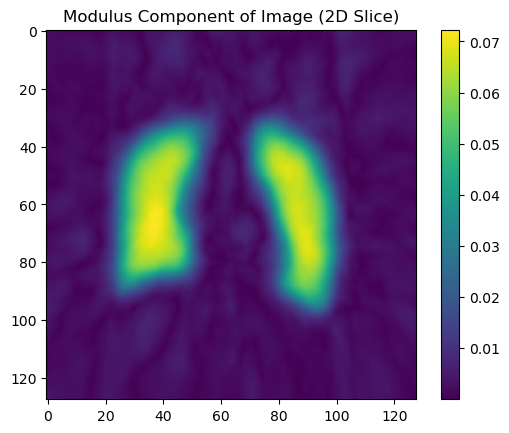

In [253]:
# display modulus of image (single slice)
DisplayImageSlice(image_lung_16000) 

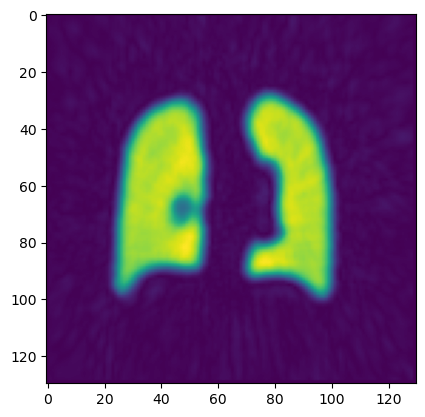

In [273]:
makeSlide(image_lung_64000[:,:,75:76])

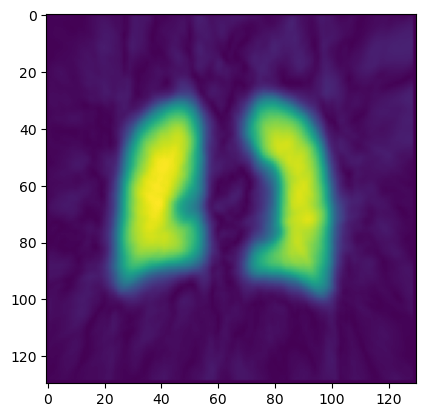

In [271]:
makeSlide(image_lung_16000[:,:,75:76])

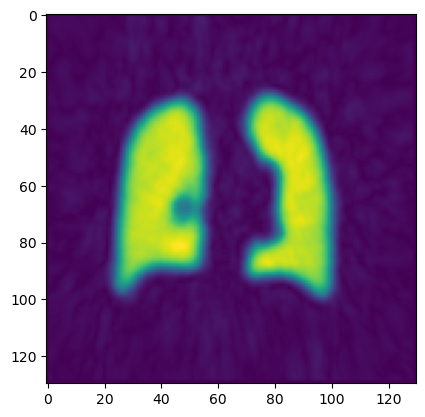

In [283]:
makeSlide(image_lung_48000[:,:,75:76])

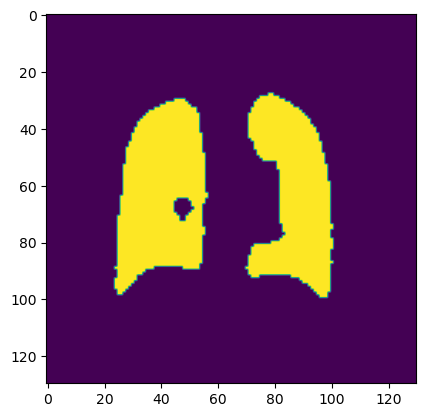

In [274]:
makeSlide(image_lung_original[:,:,75:76])

In [255]:
# normalizing
image_lung_16000_norm = (image_lung_16000 - np.min(image_lung_16000)) / (np.max(image_lung_16000) - np.min(image_lung_16000))


In [126]:
image_lung_original = np.load('DataSynthesizer/data/GAS.np.npy')

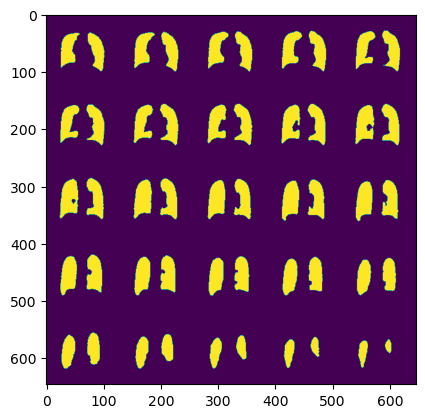

In [127]:
makeSlide(image_lung_original[:,:,65:90])

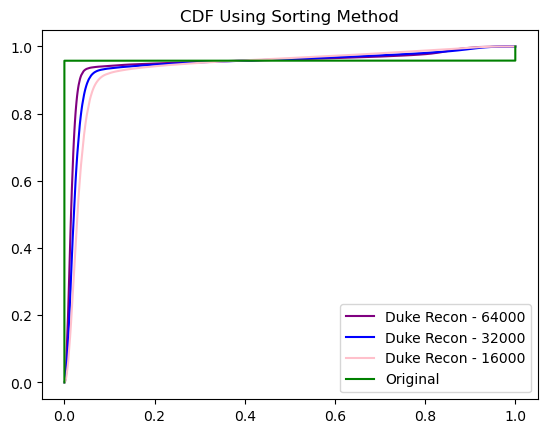

In [284]:
# Cumulative Distribution Function (CDF)  
# duke recon
x_0 = np.sort(image_lung_64000_norm.ravel())
y_0 = np.arange(len(image_lung_64000_norm.ravel())) / float(len(image_lung_64000_norm.ravel()))


x_5 = np.sort(image_lung_32000_norm.ravel())
y_5 = np.arange(len(image_lung_32000_norm.ravel())) / float(len(image_lung_32000_norm.ravel()))

x_3 = np.sort(image_lung_16000_norm.ravel())
y_3 = np.arange(len(image_lung_16000_norm.ravel())) / float(len(image_lung_16000_norm.ravel()))

# original image
x_6 = np.sort(image_lung_original.ravel())
y_6 = np.arange(len(image_lung_original.ravel())) / float(len(image_lung_original.ravel()))

plt.title('CDF Using Sorting Method')

plt.plot(x_0, y_0, color='purple', label="Duke Recon - 64000")
plt.plot(x_5, y_5, color='blue', label="Duke Recon - 32000")
plt.plot(x_3, y_3, color='pink', label="Duke Recon - 16000")
plt.plot(x_6, y_6, color='green', label='Original')

plt.legend()

Text(0.5, 1.0, 'Boxplots Comparing Original with Duke Recon ')

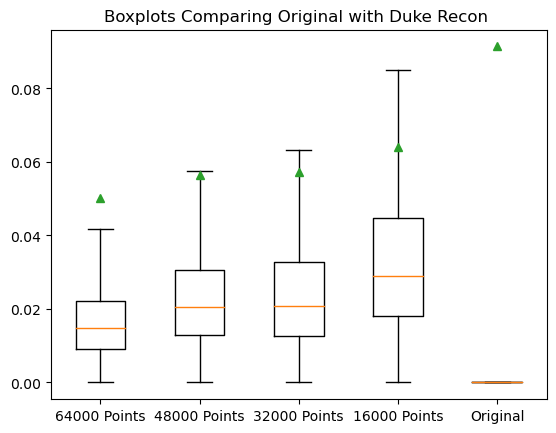

In [258]:
plt.boxplot([image_lung_64000_norm.reshape(image_lung_64000_norm.shape[1]**3),
             image_lung_48000_norm.reshape(image_lung_48000_norm.shape[1]**3),
             image_lung_32000_norm.reshape(image_lung_32000_norm.shape[1]**3),
             image_lung_16000_norm.reshape(image_lung_16000_norm.shape[1]**3),
            image128_original.reshape(image128_original.shape[1]**3)], showfliers=False, showmeans=True,
           labels=["64000 Points", '48000 Points', '32000 Points', '16000 Points', 'Original'])
plt.title('Boxplots Comparing Original with Duke Recon ')

In [259]:
from skimage.metrics import structural_similarity as compare_ssim

def calculate_ssim(original_image, reconstructed_image):
    """Calculate the Structural Similarity Index (SSIM) between two images."""
    ssim = compare_ssim(original_image, reconstructed_image, multichannel=True)
    return ssim

In [275]:
ssim = calculate_ssim(image_lung_original, image_lung_64000_norm)
print(ssim)

0.6224761563484483


/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1916230949.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(original_image, reconstructed_image, multichannel=True)


In [276]:
ssim1 = calculate_ssim(image_lung_original, image_lung_48000_norm)
print(ssim1)

0.48588853870119497


/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1916230949.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(original_image, reconstructed_image, multichannel=True)


In [277]:
ssim2 = calculate_ssim(image_lung_original, image_lung_32000_norm)
print(ssim2)

0.47631914572548406


/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1916230949.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(original_image, reconstructed_image, multichannel=True)


In [278]:
ssim3 = calculate_ssim(image_lung_original, image_lung_16000_norm)
print(ssim2)

0.47631914572548406


/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1916230949.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = compare_ssim(original_image, reconstructed_image, multichannel=True)


In [279]:
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as calculate_psnr
from skimage.metrics import structural_similarity as calculate_ssim

def compare_quality(original_image, reconstructed_image):
    """Compare the quality of the reconstructed image with the original."""
    # Compute PSNR
    psnr = calculate_psnr(original_image, reconstructed_image)

    # Compute SSIM
    ssim = calculate_ssim(original_image, reconstructed_image, multichannel=True)

    return psnr, ssim

# Load or generate the original phantom image and reconstructed images
reconstructed_images = [image_lung_60000_norm, image_lung_48000_norm, image_lung_32000_norm, image_lung_16000_norm]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['PSNR', 'SSIM'])

# Calculate PSNR and SSIM for each reconstructed image
for i, reconstructed_image in enumerate(reconstructed_images):
    psnr, ssim = compare_quality(image_lung_original, reconstructed_image)
    results_df.loc[i] = [psnr, ssim]

/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1452282866.py:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = calculate_ssim(original_image, reconstructed_image, multichannel=True)
/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1452282866.py:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = calculate_ssim(original_image, reconstructed_image, multichannel=True)
/var/folders/rs/k6rx45z10bj_mym3tbcjr6w40000gn/T/ipykernel_53788/1452282866.py:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = calculate_ssim(original_image, reconstructed_image, multichannel=True)
/var/folders/rs/k6rx45z10bj_mym3tb

In [282]:
# Display the DataFrame with results
# Set index names
index_names = ['Duke Recon - 64000', 'Duke Recon - 48000', 'Duke Recon - 32000', 'Duke Recon - 16000']
results_df.index = index_names

results_df

,PSNR,SSIM
Duke Recon - 64000,23.163807,0.573058
Duke Recon - 48000,22.692966,0.485889
Duke Recon - 32000,22.028924,0.476319
Duke Recon - 16000,20.412060,0.354972
